In [4]:
#notebook for Bayesian analysis of isothermal titration calorimetry data
#This notebook includes methods for generating synthetic data as well as reading experimental data
#and allows for modeling with fixed concentrations as well as modeled concentrations with adjustable priors

#imports for running analysis
import numpy as np
import emcee 
import itcfunctions as itc
from multiprocessing import Pool

##some params that cannot easily be read
##while Kb is unlikely to change, T and V0 will be instrument/experiment dependent
#boltzmann constant
Kb = 0.001987  
#Temperature
T = 273.15+25  
#initial volume in ITC cell, L units
V0 = 1.42e-3   

itc_constants = [Kb,T,V0]



##simple function for reading CSV file of injection volumes and integrated heats
#converts from expected values in uL (injection volume) and ucal -- default outputs from table in origin 
#see included example file for formatting.
def get_data(file_name):
    inj_list = np.empty(shape=(0))
    dq_list = np.empty(shape=(0))
    with open(file_name) as F:
        for line in F:
            values = line.strip('\n').split(',')
            inj_list = np.append(inj_list,float(values[1])*1e-6)
            dq_list = np.append(dq_list,float(values[0]))
    return [inj_list],dq_list
            


In [5]:
# initialization

#option for enabling or disabling concentrations. When set to off, concentrations are treated as fixed values
#set to True or False
conc_priors = False

#number of injections to remove from front of isotherm (1 by default)
skipped_injections = 1

#filename for save and for plots
filename = 'run1_10prior'

#seed for addition of noise to synthetic ITC data
seed = 555

#synthetic data generation. More info & model parameters listed in itcfunctions
true_y, y_obs,theta_true,injection_list = itc.get_synthetic_itc(seed)


#function to read data from a file. either this line or above line for generating synthetic data should be commented out.
#injection_list,y_obs = get_data('examdata.csv')


#reseed for random starts -- the seed here will determine the number generation for start points and MCMC move selection
seed = 101112
np.random.seed(seed)

##initial concentrations (in M units). These will need to be set manually for experimental data (example commented out below) 
pt_initial = theta_true[4]
lt_initial = theta_true[5]

#pt_initial = 1e-3
#lt_initial = 15e-6


# sampler settings
n_walkers = 50  # at least 3x the number of parameters
n_steps = int(5e2)  # at least 50x the autocorrelation time

#range for uniform prior for analyte concentrations. Value is a fraction of stated initial (i.e. 0.1 = +/- 10%)
pt_range = 0.1
lt_range = 0.1

#set number of dimensions
if conc_priors:
    n_dim = 8
else:
    n_dim = 6



##log likelihood function
def log_likelihood(theta, y_obs, injection_list):
    '''log of Guassian likelihood distribution'''
    
    #sigma should be last item in theta list
    curr_sigma = theta[-1]
    
    #calculate heats for synthetic data. More info in Itcfunctions
    if conc_priors:
        y_pred = itc.get_dq_list(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],injection_list,itc_constants)
    else:
        y_pred = itc.get_dq_list(theta[0],theta[1],theta[2],theta[3],pt_initial,lt_initial,theta[4],injection_list,itc_constants)

    # calculate normal log likelihood
    logl = -len(y_obs[skipped_injections:]) * np.log(np.sqrt(2.0 * np.pi) * curr_sigma)
    #removed injections # 0 to skipped_injections from likelihood function
    logl += -np.sum((y_obs[skipped_injections:] - y_pred[skipped_injections:]) ** 2.0) / (2.0 * curr_sigma ** 2.0) 
    return logl


#function for determining prior
def log_prior(theta):

    
    #set true concentrations (for determining prior range)
    pt_initial_true = pt_initial
    lt_initial_true = lt_initial
    
    #read parameters from theta
    dg = theta[0]
    ddg = theta[1]
    dh = theta[2]
    ddh = theta[3]
    if conc_priors:
        pt = theta[4]
        lt = theta[5]
        dh_0 = theta[6]
    else:
        dh_0 = theta[4]
        
    #sigma must be last entry in [theta]
    sigma = theta[-1]

    # if prior is between boundary --> log(prior) = 0, else prior = -infinity
    #see notes below for implementing gaussian priors
    if 0.001<sigma<1 and -10<dg<-5 and -4.1<ddg<4.1 and -20<dh<0 and -10<ddh<10  and -10<dh_0<10:
        if conc_priors:
            if (pt_initial_true-pt_initial_true*pt_range)<pt<(pt_initial_true+pt_initial_true*pt_range) \
            and (lt_initial_true-lt_initial_true*lt_range)<lt<(lt_initial_true+lt_initial_true*lt_range):
                return 0
            else:
                return -np.inf
        else:
            return 0
    else:
        return -np.inf


#function that emcee will call -- determines log probability from log prior and log likelihood
def log_probability(theta, y_obs, injection_list):
    '''log of estimated posterior probability'''
    logp = log_prior(theta)
    
    #return -infinity if outside of prior
    if not np.isfinite(logp):
        return -np.inf  # ~zero probability
    return logp + log_likelihood(theta, y_obs, injection_list)  # log posterior ~ log likelihood + log prior



# Set up the backend -- emcee's built-in backend works well
backend = emcee.backends.HDFBackend(f'save_{filename}.dat')
# clear in case the file already exists (remove this line when restarting from paused sampling)
backend.reset(n_walkers, n_dim)



# random starts from uniform priors
pos_list = []
#choose random position within desired range (set to prior range by default here)
for i in range(n_walkers):
    sigma_i = np.random.uniform(0.001,1)
    dg_i = np.random.uniform(-10,-5)
    ddg_i = np.random.uniform(-4,4)
    dh_i = np.random.uniform(-20,0)
    ddh_i = np.random.uniform(-10,10)
    if conc_priors:
        pt_i = np.random.uniform(pt_initial-pt_initial*pt_range, pt_initial+pt_initial*pt_range)
        lt_i = np.random.uniform(lt_initial-lt_initial*pt_range, lt_initial+lt_initial*lt_range)
    dh_0_i = np.random.uniform(-10,10)
    if conc_priors:
        pos_list.append([dg_i,ddg_i,dh_i,ddh_i,pt_i,lt_i,dh_0_i,sigma_i])
    else:
        pos_list.append([dg_i,ddg_i,dh_i,ddh_i,dh_0_i,sigma_i])
        
start_pos = np.asarray(pos_list)

# run emcee ensemble sampler
# see EMCEE docs for more options and info
with Pool(processes=4) as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability,  args=(y_obs,injection_list),
                                    backend=backend, pool=pool, 
                                    moves=[(emcee.moves.StretchMove(),0.8),
                                            (emcee.moves.DEMove(),0),
                                            (emcee.moves.DESnookerMove(),0.2)])
    sampler.run_mcmc(start_pos, n_steps, progress=True)



[2e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06, 6e-06]
Could not find root
-9.325592420740556 -3.9645704999762277 -16.232990357289598 8.731348664662683 17
[1.02383327e-06 4.04911352e-10]
Could not find root
-9.551015153273005 -3.927493793662417 -3.9099862028581853 1.0499235002721754 17
[6.99417826e-07 4.34961772e-10]


  2%|▏         | 9/500 [00:01<01:08,  7.20it/s]

Could not find root
-9.861009649618152 -3.1014622388595603 -15.37049224062309 5.167524601365236 17
[1.00706507e-06 2.95040238e-10]


100%|██████████| 500/500 [01:20<00:00,  6.21it/s]


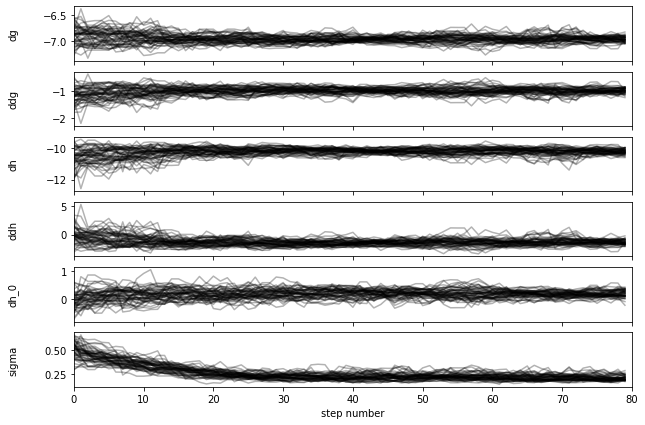

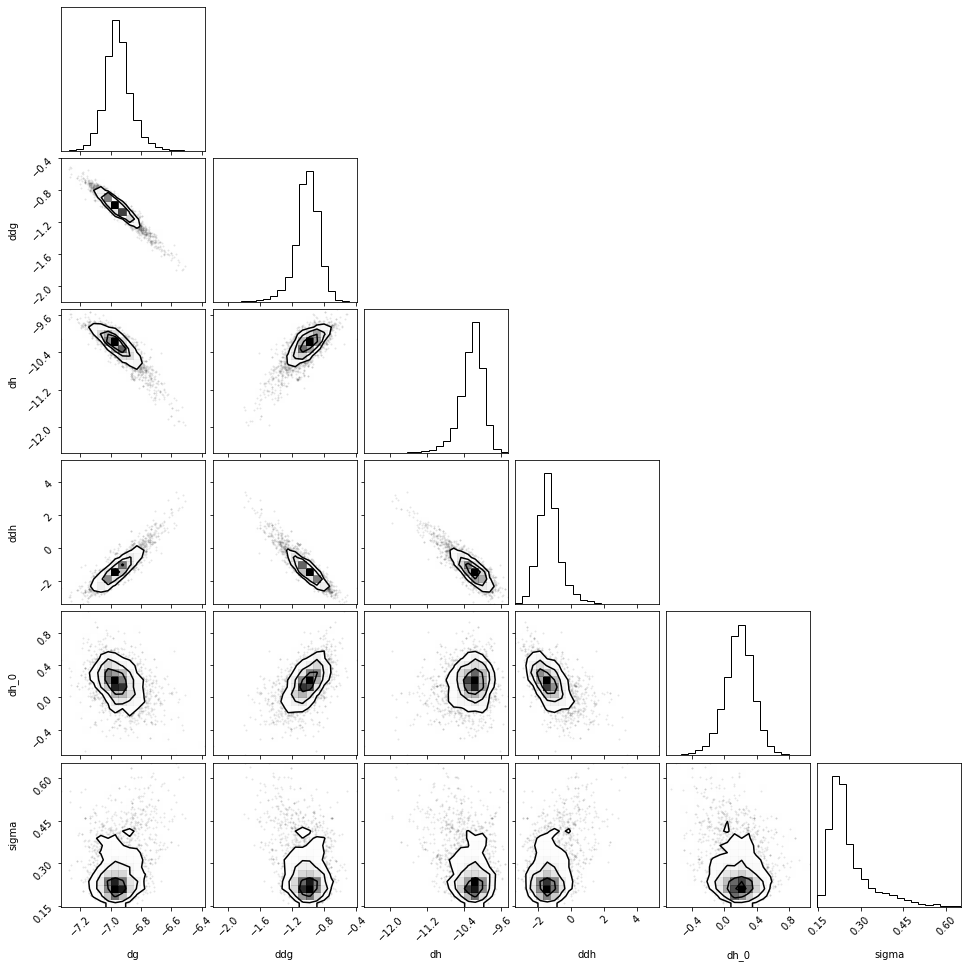

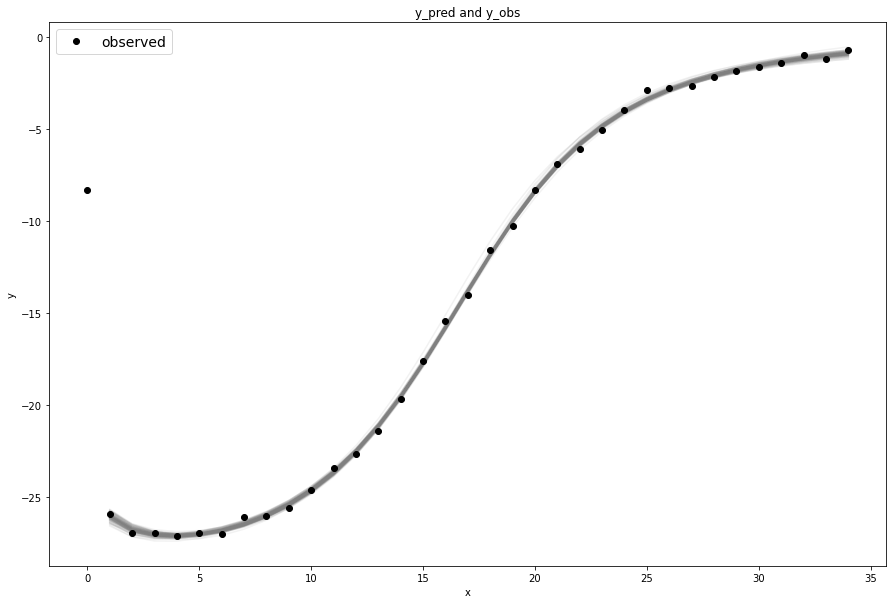

In [6]:
### 7 parameter itc model analysis
import matplotlib.pyplot as plt
import corner 

#retrieve saved data (not always needed, comment out when unused)
import emcee
import numpy as np
import itcfunctions as itc

#can be set to a different filename if old data needs to be read
sampler = emcee.backends.HDFBackend(f'save_{filename}.dat')

#set thin and burn_in
thin = 5
burn_in = 100

#read samples 
samples = sampler.get_chain(thin=thin,discard=burn_in)
n_dim = len(samples[0][1])

# mcmc trajectory (before burn in)
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
if conc_priors:
    labels = ["dg", "ddg", "dh", "ddh", "pt", "lt", "dh_0", "sigma"]
else:
    labels = ["dg", "ddg", "dh", "ddh", "dh_0", "sigma"]
    
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(f'{filename}_traces.png')
# autocorrelation time (for measuring sampling performance)
# note: this can give an error if the run length isn't 50x the autocorrelation
#tau = sampler.get_autocorr_time()
#print(tau)


# corner plot (1d and 2d histograms) 
# see corner API for more information and plotting help
flat_samples = sampler.get_chain(discard=burn_in, thin=thin, flat=True)
fig = corner.corner(flat_samples,labels=labels)
plt.savefig(f'{filename}_2dcorr.png')


# plot y_predicted and y_observed
#get 100 random samples
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize = (15, 10))
for ind in inds:
    sample = flat_samples[ind]
    
    #get predicted y for each sample 
    if conc_priors:
        y_pred_i = itc.get_dq_list(sample[0],sample[1],sample[2],sample[3],
                                    sample[4], sample[5], sample[6],injection_list,itc_constants)
    else:
        y_pred_i = itc.get_dq_list(sample[0],sample[1],sample[2],sample[3],
                                    pt_initial,lt_initial, sample[4],injection_list,itc_constants)
    ##skips plotting points that are skipped in modeling
    plt.plot(range(skipped_injections,len(y_pred_i)),y_pred_i[skipped_injections:], alpha=0.1, color='grey')
plt.title('y_pred and y_obs')
plt.ylabel('y')
plt.xlabel('x')

plt.plot(y_obs, ls='None', color='black', marker='o',label="observed")
plt.legend(fontsize=14)

plt.savefig(f'{filename}_example_plots.png')